# 2D slopes

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [4]:
ds_659_rho = xr.open_dataset('data/sg_O2_659_isopycnal_grid_4m_27_sept_2021.nc')
ds_660_rho = xr.open_dataset('data/sg_O2_660_isopycnal_grid_4m_27_sept_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)
#alpha = 8.3012133e-05
#beta  = 0.00077351

#
dCT_659 = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA_659 = ds_659_rho.SA  - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT_659).rename('Spice')

# remove a mean per isopycnal
dCT_660 = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA_660 = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT_660).rename('Spice')

In [5]:
from scipy import interpolate

In [6]:
def interp_distance(ds, var, vert_axis = 'ctd_pressure'): 

    #print (ds.longitude.mean(vert_axis))
    distance = np.cumsum(gt.utils.distance(ds.longitude.mean(vert_axis), 
                                           ds.latitude.mean(vert_axis)))
    
    #print(distance)
    dist_grid = np.arange(0, distance.max(), 500)

    for i in range(len(ds[vert_axis])): 
        
        #ds_temp = ds.isel(ctd_pressure=i) # would be nice if this was indexed without the hard coding
         
        #data = ds_temp[var].values
        
        ds_temp = ds[var][i,:]
        data = ds_temp.values
        
        f = interpolate.interp1d(distance, data, fill_value=np.nan)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, vert_axis: ds_temp[vert_axis]}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim=vert_axis)
        
    return da_var_int
            

In [ ]:
ds_659_rho_dist = xr.merge( [interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

In [14]:
ds_660_rho_dist = xr.merge( [interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

In [11]:
ds_660_rho_dist

<xarray.Dataset>
Dimensions:       (distance: 3407, rho_grid: 901)
Coordinates:
  * distance      (distance) float64 0.0 500.0 1e+03 ... 1.702e+06 1.703e+06
  * rho_grid      (rho_grid) float64 26.9 26.9 26.9 26.9 ... 27.8 27.8 27.8 27.8
Data variables:
    CT            (rho_grid, distance) float64 3.576 3.565 3.564 ... nan nan nan
    SA            (rho_grid, distance) float64 33.99 33.99 33.99 ... nan nan nan
    Oxygen        (rho_grid, distance) float64 321.5 321.1 321.1 ... nan nan nan
    ctd_pressure  (rho_grid, distance) float64 16.22 18.29 17.45 ... nan nan nan

In [10]:
# Function that regrids a single dive 
# Will be rung in a loop to do interpolation for all dives.

def func_var_int_pmean(ds, Pmean_smooth_dist): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_dist
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [15]:
# For 660 
time_ind = 0

Pmean_smooth = ds_660_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.75))
spice_on_Pmean_660 = func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=0), Pmean_smooth)

for dist_ind in range(1, len(ds_660_rho_dist.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_660 = xr.concat([spice_on_Pmean_660, 
                                func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')

400
800
1200
1600
2000
2400
2800
3200


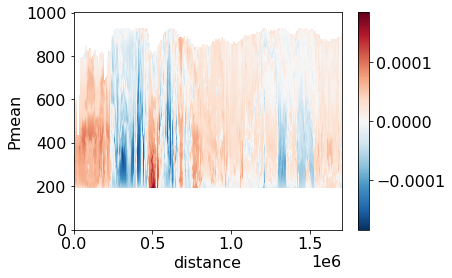

In [17]:
spice_on_Pmean_660.plot()

In [26]:
spice_on_Pmean_660

<xarray.DataArray (Pmean: 501, distance: 3407)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Pmean     (Pmean) float64 0.0 2.0 4.0 6.0 8.0 ... 994.0 996.0 998.0 1e+03
  * distance  (distance) float64 0.0 500.0 1e+03 ... 1.702e+06 1.703e+06

In [30]:
dSdx = np.abs(spice_on_Pmean_660.diff('distance')/ spice_on_Pmean_660.distance.diff('distance'))
dSdz = np.abs(spice_on_Pmean_660.diff('Pmean')/ spice_on_Pmean_660.Pmean.diff('Pmean'))

In [43]:
dSdx[:-1,:]

<xarray.DataArray (Pmean: 500, distance: 3406)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Pmean     (Pmean) float64 0.0 2.0 4.0 6.0 8.0 ... 992.0 994.0 996.0 998.0
  * distance  (distance) float64 500.0 1e+03 1.5e+03 ... 1.702e+06 1.703e+06

In [44]:
dSdz[:,:-1]

<xarray.DataArray (Pmean: 500, distance: 3406)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * Pmean     (Pmean) float64 2.0 4.0 6.0 8.0 10.0 ... 994.0 996.0 998.0 1e+03
  * distance  (distance) float64 0.0 500.0 1e+03 ... 1.702e+06 1.702e+06

(array([ 13.,   4.,  59., 121., 263., 654., 773., 969., 468.,  57.]),
 array([-12.18550541, -11.6565666 , -11.12762778, -10.59868897,
        -10.06975016,  -9.54081134,  -9.01187253,  -8.48293371,
         -7.9539949 ,  -7.42505608,  -6.89611727]),
 <BarContainer object of 10 artists>)

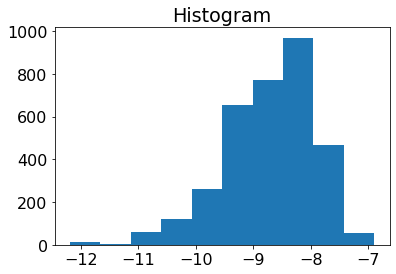

In [33]:
np.log10(dSdx).sel(Pmean=400, method='nearest').plot.hist()


(array([  10.,   19.,   83.,  224.,  574.,  966., 1119.,  353.,   31.,
           3.]),
 array([-9.50435137, -8.99365274, -8.48295411, -7.97225547, -7.46155684,
        -6.95085821, -6.44015958, -5.92946095, -5.41876232, -4.90806369,
        -4.39736505]),
 <BarContainer object of 10 artists>)

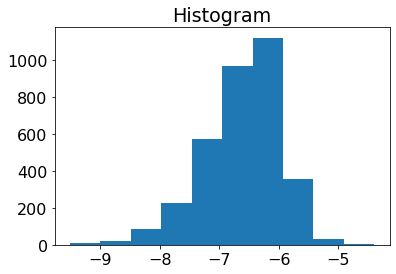

In [34]:
np.log10(dSdz).sel(Pmean=400, method='nearest').plot.hist()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


Text(0, 0.5, '|d Spice /dz|')

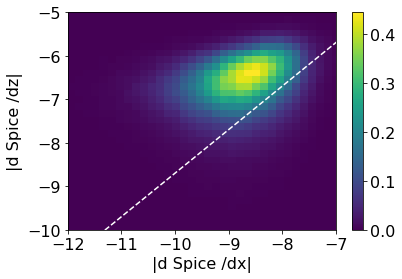

In [100]:
H , xedges, yedges = np.histogram2d(np.log10(dSdx[:-1,:].values.reshape(-1)), np.log10(dSdz[:, :-1].values.reshape(-1)),
           bins=[np.linspace(-12, -6, 41), np.linspace(-10, -4, 40)], density=True   );

plt.pcolormesh(xedges[:-1], yedges[:-1], H.T)

plt.plot(xedges, xedges + np.log10(20),'--', color='w')

plt.colorbar()

plt.axis([-12, -7, -10, -5])

plt.xlabel('|d Spice /dx|')
plt.ylabel('|d Spice /dz|')

In [53]:
slope = dSdz.mean('distance') / dSdx.mean('distance')

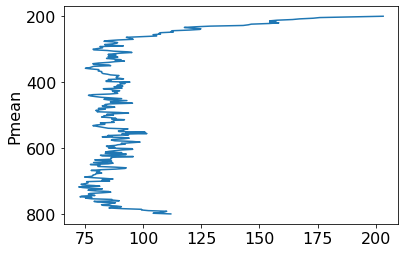

In [98]:
(slope).sel(Pmean=slice(200,800)).plot(y='Pmean')
plt.gca().invert_yaxis()
